<a href="https://colab.research.google.com/github/prometheusDE/mylastai/blob/master/mylastai_0008_project_handlevideo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


1. Install Tensorflow and Tensorflow Dataset Extension

In [1]:
%%capture
!pip install tensorflow==2.1.0
!pip install matplotlib==3.2.1

!nvcc --version

!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist/cuda/10.0 nvidia-dali
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist/cuda/10.0 nvidia-dali-tf-plugin

2. Handle Video File

In [4]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy as np
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import os.path

# https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/examples/sequence_processing/video/video_reader_simple_example.html

In [13]:
batch_size=10
sequence_length=8
initial_prefetch_size=16
# video_directory = '/content/gdrive/My Drive/CycleAI/20200308'
video_directory = '/home/backhaus/Videos/Process'
video_files=[video_directory + '/' + f for f in os.listdir(video_directory)]
shuffle=True
n_iter=1

In [10]:
print(video_files)

['/home/backhaus/Videos/Process/2020-04-08_CycleAI_0012_Irxleben_001.m4v']


In [26]:
class VideoPipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, data, shuffle):
        super(VideoPipe, self).__init__(batch_size, num_threads, device_id, seed=16)
        self.input = ops.VideoReader(device="gpu", filenames=data, sequence_length=sequence_length,
                                     shard_id=0, num_shards=1,
                                     random_shuffle=shuffle, initial_fill=initial_prefetch_size)


    def define_graph(self):
        output = self.input(name="Reader")
        return output

In [25]:
pipe = VideoPipe(batch_size=batch_size, num_threads=2, device_id=0, data=video_files, shuffle=shuffle)
pipe.build()
for i in range(n_iter):
    pipe_out = pipe.run()
    sequences_out = pipe_out[0].as_cpu().as_array()
    print(sequences_out.shape)

RuntimeError: [/opt/dali/dali/pipeline/operator/operator_factory.h:54] Assert on "creator_it != registry_.end()" failed: Operator "VideoReader" not registered for cpu.
Stacktrace (100 entries):
[frame 0]: /home/backhaus/Entwicklung/mylastai/venv/lib/python3.7/site-packages/nvidia/dali/libdali.so(+0xa0e7e) [0x7fa2d40dbe7e]
[frame 1]: /home/backhaus/Entwicklung/mylastai/venv/lib/python3.7/site-packages/nvidia/dali/libdali.so(+0x16231a) [0x7fa2d419d31a]
[frame 2]: /home/backhaus/Entwicklung/mylastai/venv/lib/python3.7/site-packages/nvidia/dali/libdali.so(dali::InstantiateOperator(dali::OpSpec const&)+0x32f) [0x7fa2d419ca9f]
[frame 3]: /home/backhaus/Entwicklung/mylastai/venv/lib/python3.7/site-packages/nvidia/dali/libdali.so(dali::OpGraph::InstantiateOperators()+0xa7) [0x7fa2d4159117]
[frame 4]: /home/backhaus/Entwicklung/mylastai/venv/lib/python3.7/site-packages/nvidia/dali/libdali.so(dali::Pipeline::Build(std::vector<std::pair<std::string, std::string>, std::allocator<std::pair<std::string, std::string> > >)+0xa48) [0x7fa2d41b72a8]
[frame 5]: /home/backhaus/Entwicklung/mylastai/venv/lib/python3.7/site-packages/nvidia/dali/backend_impl.cpython-37m-x86_64-linux-gnu.so(+0x3f0df) [0x7fa2d4d110df]
[frame 6]: /home/backhaus/Entwicklung/mylastai/venv/lib/python3.7/site-packages/nvidia/dali/backend_impl.cpython-37m-x86_64-linux-gnu.so(+0x1d033) [0x7fa2d4cef033]
[frame 7]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyCFunction_FastCallKeywords+0x1ab) [0x55c08af072bb]
[frame 8]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1f71) [0x55c08af9df71]
[frame 9]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x4962) [0x55c08af9b042]
[frame 10]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalCodeWithName+0x300) [0x55c08af95b10]
[frame 11]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyFunction_FastCallKeywords+0x19e) [0x55c08af096de]
[frame 12]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1deb) [0x55c08af9ddeb]
[frame 13]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x609) [0x55c08af96ce9]
[frame 14]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(PyEval_EvalCode+0xef) [0x55c08af9532f]
[frame 15]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1a7540) [0x55c08af93540]
[frame 16]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyCFunction_FastCallKeywords+0x84) [0x55c08af07194]
[frame 17]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1ef4) [0x55c08af9def4]
[frame 18]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x578) [0x55c08af96c58]
[frame 19]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyGen_Send+0x272) [0x55c08b02efa2]
[frame 20]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x167b) [0x55c08af97d5b]
[frame 21]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyGen_Send+0x272) [0x55c08b02efa2]
[frame 22]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x167b) [0x55c08af97d5b]
[frame 23]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyGen_Send+0x272) [0x55c08b02efa2]
[frame 24]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyMethodDef_RawFastCallKeywords+0x22b) [0x55c08af0786b]
[frame 25]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyMethodDescr_FastCallKeywords+0x51) [0x55c08b02cca1]
[frame 26]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1ec6) [0x55c08af9dec6]
[frame 27]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x609) [0x55c08af96ce9]
[frame 28]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyFunction_FastCallKeywords+0x10a) [0x55c08af0964a]
[frame 29]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1deb) [0x55c08af9ddeb]
[frame 30]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x578) [0x55c08af96c58]
[frame 31]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyFunction_FastCallKeywords+0x10a) [0x55c08af0964a]
[frame 32]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1deb) [0x55c08af9ddeb]
[frame 33]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x609) [0x55c08af96ce9]
[frame 34]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalCodeWithName+0x300) [0x55c08af95b10]
[frame 35]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyObject_Call_Prepend+0x63c) [0x55c08af0ae5c]
[frame 36]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(PyObject_Call+0x76) [0x55c08af0b0f6]
[frame 37]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x1ae3) [0x55c08af981c3]
[frame 38]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalCodeWithName+0x300) [0x55c08af95b10]
[frame 39]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyFunction_FastCallKeywords+0x19e) [0x55c08af096de]
[frame 40]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1deb) [0x55c08af9ddeb]
[frame 41]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x128a) [0x55c08af9796a]
[frame 42]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x241d85) [0x55c08b02dd85]
[frame 43]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1a88f0) [0x55c08af948f0]
[frame 44]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyCFunction_FastCallKeywords+0x84) [0x55c08af07194]
[frame 45]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1ef4) [0x55c08af9def4]
[frame 46]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x578) [0x55c08af96c58]
[frame 47]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalCodeWithName+0x300) [0x55c08af95b10]
[frame 48]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyFunction_FastCallKeywords+0x19e) [0x55c08af096de]
[frame 49]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1deb) [0x55c08af9ddeb]
[frame 50]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x609) [0x55c08af96ce9]
[frame 51]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x241d85) [0x55c08b02dd85]
[frame 52]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1a88f0) [0x55c08af948f0]
[frame 53]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyCFunction_FastCallKeywords+0x84) [0x55c08af07194]
[frame 54]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1ef4) [0x55c08af9def4]
[frame 55]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x578) [0x55c08af96c58]
[frame 56]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalCodeWithName+0x300) [0x55c08af95b10]
[frame 57]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyFunction_FastCallKeywords+0x19e) [0x55c08af096de]
[frame 58]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1deb) [0x55c08af9ddeb]
[frame 59]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x578) [0x55c08af96c58]
[frame 60]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x241d85) [0x55c08b02dd85]
[frame 61]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1a88f0) [0x55c08af948f0]
[frame 62]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyCFunction_FastCallKeywords+0x84) [0x55c08af07194]
[frame 63]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1ef4) [0x55c08af9def4]
[frame 64]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x578) [0x55c08af96c58]
[frame 65]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalCodeWithName+0x300) [0x55c08af95b10]
[frame 66]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyObject_Call_Prepend+0x39a) [0x55c08af0abba]
[frame 67]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(PyObject_Call+0x76) [0x55c08af0b0f6]
[frame 68]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x1ae3) [0x55c08af981c3]
[frame 69]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyGen_Send+0x148) [0x55c08b02ee78]
[frame 70]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyMethodDef_RawFastCallKeywords+0x22b) [0x55c08af0786b]
[frame 71]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyMethodDescr_FastCallKeywords+0x51) [0x55c08b02cca1]
[frame 72]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1ec6) [0x55c08af9dec6]
[frame 73]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x609) [0x55c08af96ce9]
[frame 74]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyFunction_FastCallKeywords+0x10a) [0x55c08af0964a]
[frame 75]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1deb) [0x55c08af9ddeb]
[frame 76]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x609) [0x55c08af96ce9]
[frame 77]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalCodeWithName+0x300) [0x55c08af95b10]
[frame 78]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyObject_FastCallDict+0x2e9) [0x55c08af07d59]
[frame 79]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x2c4f11) [0x55c08b0b0f11]
[frame 80]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyObject_FastCallKeywords+0x95) [0x55c08af089a5]
[frame 81]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1f71) [0x55c08af9df71]
[frame 82]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x578) [0x55c08af96c58]
[frame 83]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyFunction_FastCallKeywords+0x10a) [0x55c08af0964a]
[frame 84]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1deb) [0x55c08af9ddeb]
[frame 85]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x609) [0x55c08af96ce9]
[frame 86]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalCodeWithName+0x300) [0x55c08af95b10]
[frame 87]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyFunction_FastCallKeywords+0x19e) [0x55c08af096de]
[frame 88]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x288233) [0x55c08b074233]
[frame 89]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(PyCFunction_Call+0x18b) [0x55c08af0b38b]
[frame 90]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x5bce) [0x55c08af9c2ae]
[frame 91]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyFunction_FastCallKeywords+0x10a) [0x55c08af0964a]
[frame 92]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1deb) [0x55c08af9ddeb]
[frame 93]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x609) [0x55c08af96ce9]
[frame 94]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyFunction_FastCallKeywords+0x10a) [0x55c08af0964a]
[frame 95]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1deb) [0x55c08af9ddeb]
[frame 96]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x609) [0x55c08af96ce9]
[frame 97]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyFunction_FastCallKeywords+0x10a) [0x55c08af0964a]
[frame 98]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(+0x1b1deb) [0x55c08af9ddeb]
[frame 99]: /home/backhaus/Entwicklung/mylastai/venv/bin/python(_PyEval_EvalFrameDefault+0x609) [0x55c08af96ce9]


3. Visualize Frames

In [16]:
pipe_out = pipe.run()
sequences_out = pipe_out[0].as_cpu().as_array()

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [18]:
def show_sequence(sequence):
    columns = 4
    rows = (sequence_length + 1) // (columns)
    fig = plt.figure(figsize = (32,(16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(sequence[j])

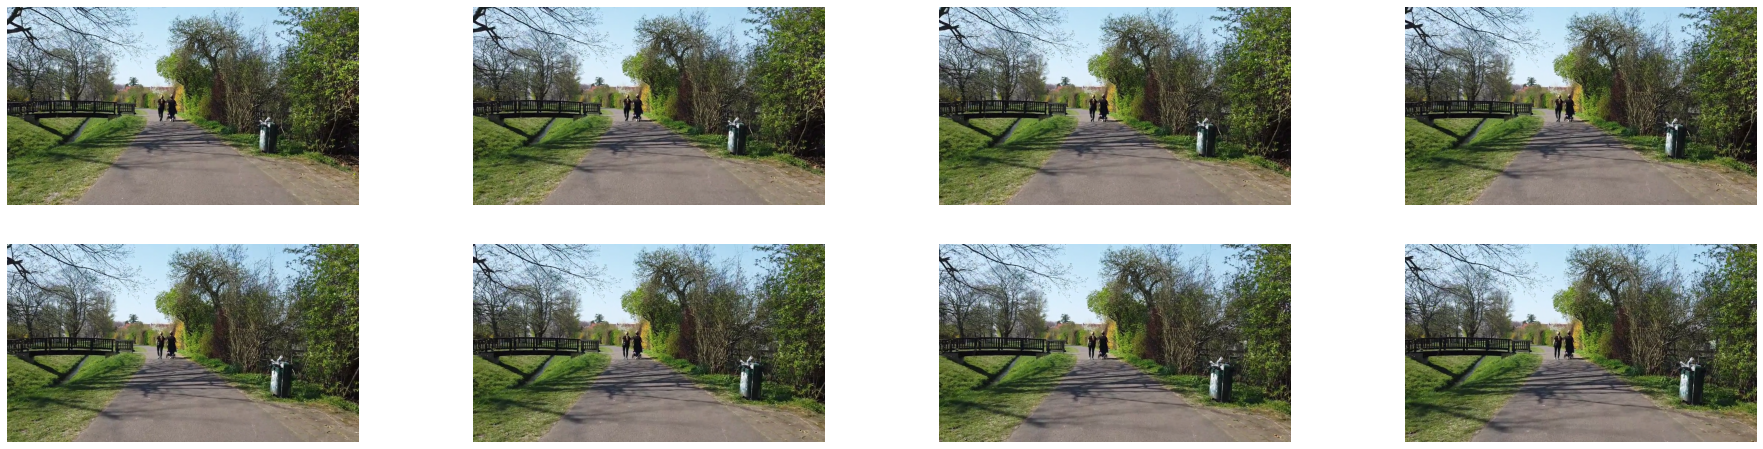

In [19]:
pipe_out = pipe.run()
sequences_out = pipe_out[0].as_cpu().as_array()
show_sequence(sequences_out[1])

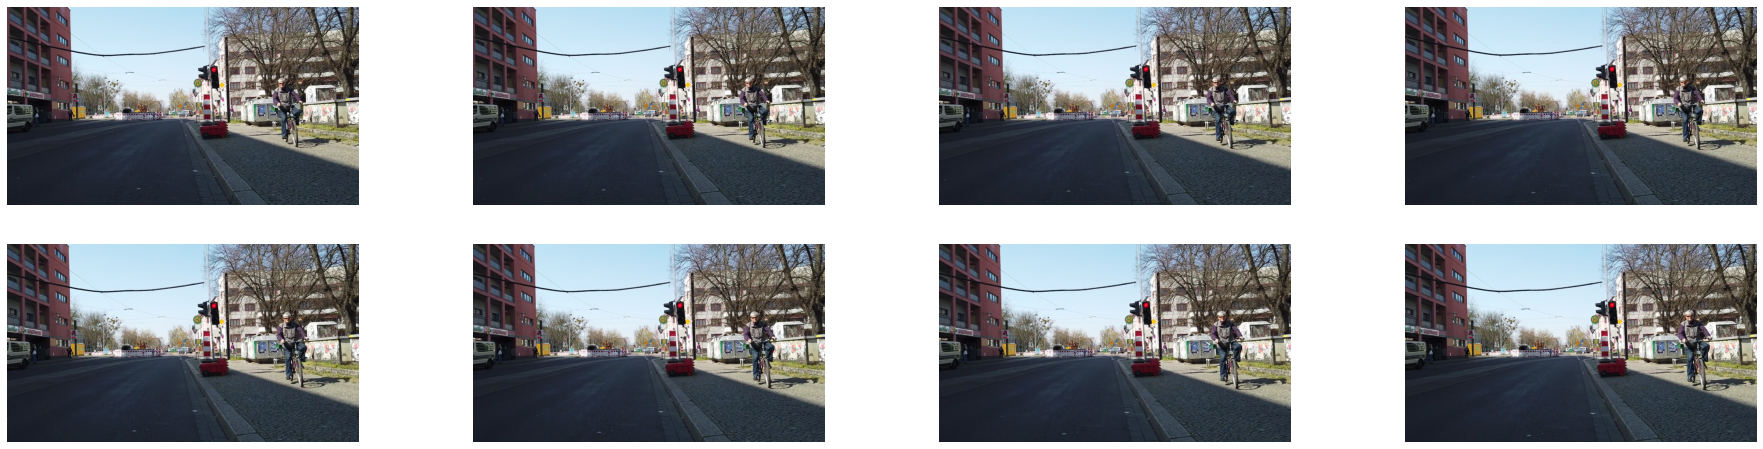

In [22]:
pipe_out = pipe.run()
sequences_out = pipe_out[0].as_cpu().as_array()
show_sequence(sequences_out[0])

4. Try to feed data into tensorflow model